<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/covidradio_weighted_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py

Mounted at /content/drive
--2021-08-28 03:25:52--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5089 (5.0K) [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]   4.97K  --.-KB/s    in 0s      

2021-08-28 03:25:52 (63.2 MB/s) - ‘util.py’ saved [5089/5089]



In [2]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.applications.densenet import DenseNet121, preprocess_input

import util

#### Get metadata on training set 

In [3]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

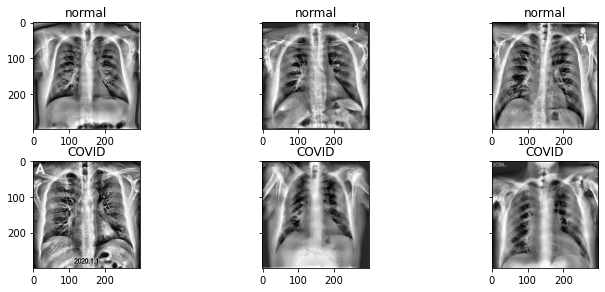

In [4]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

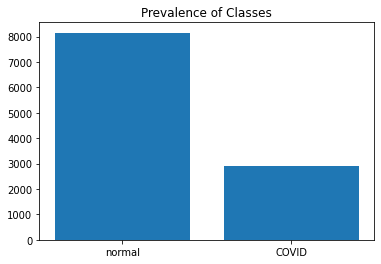

In [5]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Data generators to import images into the classifier

In [6]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'valid')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=False,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [7]:

base_model = DenseNet121(weights='imagenet', 
                         input_shape=(299, 299, 3),
                         include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# freeze up to selected top conv block
for layer in model.layers:
    if layer.name == 'conv5_block1_0_relu':
        break
    layer.trainable = False

29097984/29084464 [==============================] - 0s 0us/step


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

#### Compile and train

Epoch 1/25
346/346 [==============================] - 210s 487ms/step - loss: 0.0567 - accuracy: 0.9482 - val_loss: 0.1152 - val_accuracy: 0.9623
Epoch 2/25
346/346 [==============================] - 162s 468ms/step - loss: 0.0208 - accuracy: 0.9795 - val_loss: 0.0685 - val_accuracy: 0.9645
Epoch 3/25
346/346 [==============================] - 162s 469ms/step - loss: 0.0158 - accuracy: 0.9848 - val_loss: 0.1848 - val_accuracy: 0.9507
Epoch 4/25
346/346 [==============================] - 163s 470ms/step - loss: 0.0122 - accuracy: 0.9899 - val_loss: 0.0328 - val_accuracy: 0.9761
Epoch 5/25
346/346 [==============================] - 162s 469ms/step - loss: 0.0111 - accuracy: 0.9888 - val_loss: 0.1815 - val_accuracy: 0.9493
Epoch 6/25
346/346 [==============================] - 162s 469ms/step - loss: 0.0068 - accuracy: 0.9947 - val_loss: 0.0696 - val_accuracy: 0.9790
Epoch 7/25
346/346 [==============================] - 163s 470ms/step - loss: 0.0108 - accuracy: 0.9885 - val_loss: 0.1045 -

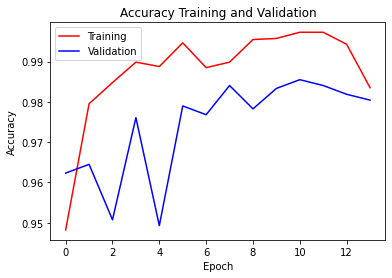

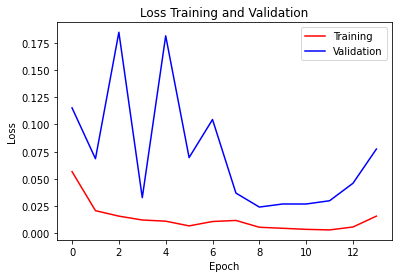

In [9]:
model.compile(loss=util.Weighted_Loss(train_gen.classes), 
              optimizer='adam', 
              metrics=['accuracy'])

stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_gen,
                    epochs=25,
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_gen,
                    validation_steps=len(valid_gen),
                    verbose=1,
                    callbacks=[stop, reduce_lr])

model_path = os.path.join(BASE_PATH, 'densenet_model.h5')
model.save(model_path)

plt.plot(history.history['accuracy'], 'r', label='Training')
plt.plot(history.history['val_accuracy'], 'b', label="Validation")
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

plt.plot(history.history['loss'], 'r', label='Training')
plt.plot(history.history['val_loss'], 'b', label="Validation")
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [10]:
from tensorflow.keras.models import load_model
model_path = os.path.join(BASE_PATH, 'densenet_model.h5')


In [13]:
model = load_model(model_path, compile=False)
model.compile(loss=util.Weighted_Loss(train_gen.classes), 
              optimizer='adam', 
              metrics=['accuracy'])

#### Evaluate the model

(Accuracy is not everything.)

In [11]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 16s 365ms/step - loss: 0.0241 - accuracy: 0.9783
Accuracy Score = 98.0%


#### Calculate confusion matrix, precision, recall, f1

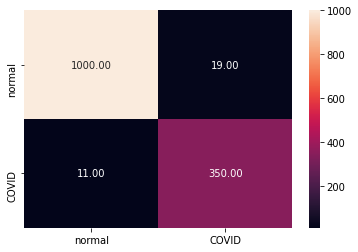

In [12]:
y_true = np.array(valid_gen.classes)
y_pred = model.predict(valid_gen)
y_pred = y_pred.reshape(-1)
y_pred = y_pred > 0.5
y_pred = y_pred.astype(np.uint8)

cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

#### Calculate Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [13]:
metrix = util.model_metrics(y_true, y_pred, classes)

data = []
for key in metrix.keys():
  class_data = [metrix[key]['accuracy'],
                metrix[key]['sensitivity'],
                metrix[key]['specificity'],
                metrix[key]['ppv'],
                metrix[key]['auc_score']]
  data.append(class_data)

metrics_df = pd.DataFrame(data, 
                          columns=['accuracy',
                                         'sensitivity',
                                         'specificity',
                                         'ppv',
                                         'auc_score'],
                          index=['COVID'])
metrics_df


,accuracy,sensitivity,specificity,ppv,auc_score
COVID,0.978261,0.969529,0.981354,0.948509,0.975442


#### ROC-AUC curve and AUC score

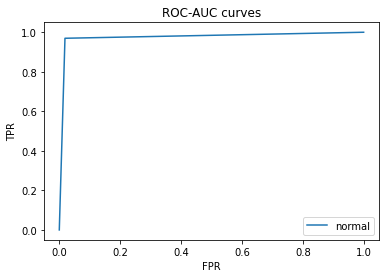

In [14]:

for key in metrix.keys():
  curve = metrix[key]['roc_curve']
  plt.plot(curve['fpr'], curve['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curves')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


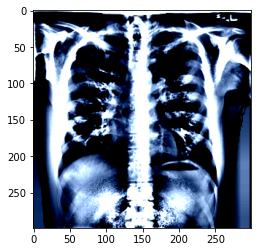

Actual class: normal
Predicted class: normal
Confidence: 99.99%


In [17]:
pick = np.random.randint(0, len(test_gen))
batch = test_gen.__getitem__(pick)

pick = np.random.randint(0, len(batch[1]))
img = batch[0][pick]
img = np.expand_dims(img, axis=0)
pred = model.predict(img)
prediction = int(pred[0][0] >= 0.5)
guess = classes[prediction]
actual = classes[int(batch[1][pick])]

if prediction:
  confidence = round(pred[0][0] * 100, 2)
else:
  confidence = round((1 - pred[0][0]) * 100, 2)

plt.imshow(batch[0][pick], cmap='gray')
plt.show()

print(f'Actual class: {actual}')
print(f'Predicted class: {guess}')
print(f'Confidence: {confidence}%')